In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [3]:
stack_fixed = 'MD602'
# stack_fixed = 'MD652'
stack_moving = 'atlasV5'
# stack_moving = 'atlasV3'

In [4]:
detector_id = 15
warp_setting = 20 # no surround
# warp_setting = 16 # incl. surround

# If using all structures, then using surround fails.

In [5]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

upstream_warp_id transform_type  terminate_thresh  \
warp_id                                                     
1                   None         affine          0.000010   
2                      1          rigid          0.000010   
4                      1          rigid          0.000001   
5                      1          rigid          0.000001   
6                      1         affine          0.000010   
7                   None          rigid          0.000001   
8                   None          rigid          0.000001   
9                      8          rigid          0.000001   
18                     8         affine          0.000001   
10                  None          rigid          0.000010   
11                     1         affine          0.000010   
12                  None         affine          0.000010   
13                  None         affine          0.000010   
14                  None        bspline          0.000010   
15                    13        bspline          0.000010   
16                  None         affine          0.000010   
17                    16          rigid          0.000001   
19                    16   weighted_avg               NaN   
20                  None         affine               NaN   
21                  None          rigid               NaN   
22                  None          rigid               NaN   
23                  None   weighted_avg               NaN   

         grad_computation_sample_number  grid_search_sample_number  std_tx_um  \
warp_id                                                                         
1                              100000.0                     1000.0       2000   
2                              100000.0                    10000.0        100   
4                              100000.0                    10000.0        100   
5                              100000.0                    10000.0        100   
6                              100000.0                    10000.0        100   
7                              100000.0                     1000.0         50   
8                              100000.0                    10000.0        200   
9                              100000.0                    10000.0       2000   
18                             100000.0                    10000.0        200   
10                             100000.0                     1000.0        100   
11                             100000.0                    10000.0        100   
12                             100000.0                     1000.0       2000   
13                             100000.0                     1000.0       2000   
14                             100000.0                     1000.0       2000   
15                             100000.0                     1000.0       2000   
16                             100000.0                     1000.0       2000   
17                             100000.0                    10000.0        200   
19                                  NaN                        NaN        200   
20                              10000.0                        NaN       2000   
21                             100000.0                    10000.0        200   
22                             100000.0                    10000.0        200   
23                                  NaN                        NaN        200   

         std_ty_um  std_tz_um  std_theta_xy_degree surround_weight  \
warp_id                                                              
1             2000       2000                   30               0   
2              100        100                   30               0   
4              100        100                   10               0   
5              100        100                   30         inverse   
6              100        100                   30            -0.5   
7               50         50                   10               0   
8              200        200         

In [6]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
if not np.isnan(warp_properties['grid_search_sample_number']):
    grid_search_sample_number = int(warp_properties['grid_search_sample_number'])
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
if not np.isnan(warp_properties['max_iter_num']):
    max_iter_num = int(warp_properties['max_iter_num'])

surround_weight = warp_properties['surround_weight']
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True

upstream_warp_id                                               None
transform_type                                               affine
terminate_thresh                                                NaN
grad_computation_sample_number                                10000
grid_search_sample_number                                       NaN
std_tx_um                                                      2000
std_ty_um                                                      2000
std_tz_um                                                      2000
std_theta_xy_degree                                              30
surround_weight                                                 NaN
regularization_weight                                           NaN
comment                           global reg no surr no grid search
max_iter_num                                                    200
Name: 20, dtype: object


In [7]:
HISTORY_LEN = 20
# MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [8]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
                                                      include_surround=include_surround)
print volume_moving[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp"
(356, 427, 375)


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp'
Volume shape: (356, 427, 375)


In [9]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, detector_id=detector_id, prep_id=2,
                                                   sided=False, volume_type='score')

print volume_fixed[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volumes/MD602_prep2_detector15_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volumes/MD602_prep2_detector15_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volumes/MD602_prep2_detector15_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volumes/MD602_prep2_detector15_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volumes/MD602_prep2_detector15_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volumes/MD602_prep2_detector15_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volumes/MD602_prep2_detector15_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volumes/MD602_prep2_detector15_down32_scoreVolume_sp5.bp"
(384, 698, 355)


File does not exist: /shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volumes/MD602_prep2_detector15_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volumes/MD602_prep2_detector15_down32_scoreVolume_sp5.bp'
Volume shape: (384, 698, 355)


# Experiment: find the smallest set of structures that still work

In [75]:
all_loaded_structures_sided = set([convert_to_nonsurround_name(s) for s in structure_to_label_moving.keys()])
all_loaded_structures = set([convert_to_original_name(s) for s in all_loaded_structures_sided])

In [ ]:
import networkx as nx
from scipy.spatial.distance import squareform, pdist
from itertools import permutations

structure_center_locations = {s: np.mean(np.where(DataManager.load_original_volume(stack=stack_moving, structure=s, downscale=32)), axis=1)
              for s in all_loaded_structures_sided}
structure_names = structure_center_locations.keys()
structure_distances = squareform(pdist(structure_center_locations.values()))
structure_distances_um = structure_distances * XY_PIXEL_DISTANCE_LOSSLESS * 32

In [39]:
def find_n_dispersed_structures(n, thresh):
    g = nx.from_numpy_matrix(structure_distances_um > thresh)
    k_cliques = [frozenset([structure_names[i] for i in c]) for c in nx.find_cliques(g) if len(c) == n]
    return set(k_cliques)
#     k_cliques = [[structure_names[i] for i in c] for c in nx.enumerate_all_cliques(g) if len(c) == n]
#     return k_cliques

In [ ]:
for min_distance_um in range(2000, 4000, 100):
#     for n_structures in range(3, 10):
    for n_structures in [9]:
        structure_subsets = find_n_dispersed_structures(n_structures, min_distance_um)
        print len(structure_subsets), 'sets of %d structures satisfy the sparsity requirements of %d um.' % (n_structures, min_distance_um)
#         print list(structure_subsets)[0]

In [43]:
min_distance_um = 2000
n_structures = 9
structure_subsets = find_n_dispersed_structures(n_structures, min_distance_um)
print list(structure_subsets)[0]

frozenset(['LRt_R', 'Sp5C_L', 'Pn_L', '6N_R', 'PBG_L', 'SC', 'SNR_R', 'VCA_R', 'DC_L'])


In [44]:
structure_subset = ['LRt_R', 'Sp5C_L', 'Pn_L', '6N_R', 'PBG_L', 'SC', 'SNR_R', 'VCA_R', 'DC_L']

# End experiment

In [10]:
# structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R','Pn_L', 'Pn_R', 'SNR_L', 'SNR_R', 
#                     'VLL_L', 'VLL_R', '7n_L', '7n_R', 'Tz_L', 'Tz_R', 
#                     'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R',
#                    'Sp5C_L', 'Sp5C_R']
structure_subset = all_known_structures_sided

In [11]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

# structure_subset = label_to_structure_moving.values()

In [12]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset}

# label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
#                      for label_m, name_m in label_to_structure_moving.iteritems()}

In [13]:
# volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

In [14]:
# structures_sorted_by_size = [x[1] for x in sorted((s, label_to_structure_moving[l]) for l, s in volume_moving_structure_sizes.iteritems())]
# print structures_sorted_by_size

In [15]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [16]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

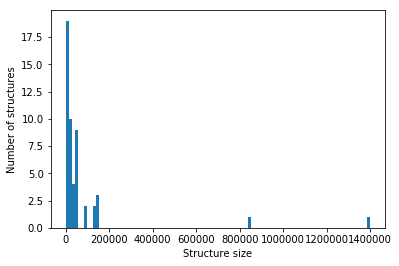

In [17]:
plt.hist(volume_moving_structure_sizes.values(), bins=100);
plt.xlabel('Structure size');
plt.ylabel('Number of structures');

In [23]:
# # Inverse positive_weight scheme.
# # If a structure size is larger than the median, re-weigh it so its total weight is equal to that of the median.

# p = np.percentile([v for k, v in volume_moving_structure_sizes.items() 
#                    if not is_surround_label(label_to_structure_moving[k])], 50)
# m = np.max(volume_moving_structure_sizes.values())
# plt.plot(np.minimum(p/np.arange(m), 1.));
# plt.xlabel('Structure size');
# plt.ylabel('Weight');
# plt.title('Inverse positive_weight scheme');

In [18]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
            label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

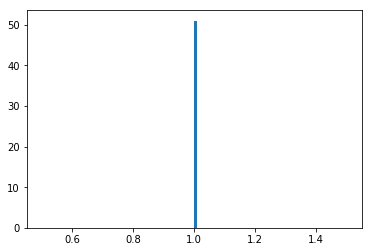

In [19]:
plt.hist(label_weights_m.values(), bins=100);

In [20]:
label_weights_m

{1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 1.0,
 12: 1.0,
 13: 1.0,
 14: 1.0,
 15: 1.0,
 16: 1.0,
 17: 1.0,
 18: 1.0,
 19: 1.0,
 20: 1.0,
 21: 1.0,
 22: 1.0,
 23: 1.0,
 24: 1.0,
 25: 1.0,
 26: 1.0,
 27: 1.0,
 28: 1.0,
 29: 1.0,
 30: 1.0,
 31: 1.0,
 32: 1.0,
 33: 1.0,
 34: 1.0,
 35: 1.0,
 36: 1.0,
 37: 1.0,
 38: 1.0,
 39: 1.0,
 40: 1.0,
 41: 1.0,
 42: 1.0,
 43: 1.0,
 44: 1.0,
 45: 1.0,
 46: 1.0,
 47: 1.0,
 48: 1.0,
 49: 1.0,
 50: 1.0,
 51: 1.0}

# Compute Registration

In [21]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                          detector_id=detector_id, 
                                                         prep_id=2)
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [22]:
gradients = {ind_f: np.zeros((3,)+volume_fixed.values()[0].shape, dtype=np.float16) 
             for ind_f in set(label_mapping_m2f.values())}

for ind_f in set(label_mapping_m2f.values()):

    t = time.time()

    download_from_s3(gradient_filepath_map_f[ind_f] % {'suffix': 'gx'}, is_dir=False)
    download_from_s3(gradient_filepath_map_f[ind_f] % {'suffix': 'gy'}, is_dir=False)
    download_from_s3(gradient_filepath_map_f[ind_f] % {'suffix': 'gz'}, is_dir=False)

    gradients[ind_f][0] = bp.unpack_ndarray_file(gradient_filepath_map_f[ind_f] % {'suffix': 'gx'})
    gradients[ind_f][1] = bp.unpack_ndarray_file(gradient_filepath_map_f[ind_f] % {'suffix': 'gy'})
    gradients[ind_f][2] = bp.unpack_ndarray_file(gradient_filepath_map_f[ind_f] % {'suffix': 'gz'})

    sys.stderr.write('load gradient %s: %f seconds\n' % (ind_f, time.time() - t)) # ~6s

load gradient 1: 9.590868 seconds
load gradient 2: 8.666437 seconds
load gradient 3: 7.709164 seconds
load gradient 4: 9.893586 seconds
load gradient 5: 8.175652 seconds
load gradient 6: 9.039967 seconds
load gradient 7: 7.839847 seconds
load gradient 8: 8.258889 seconds
load gradient 9: 12.699213 seconds
load gradient 10: 8.203786 seconds
load gradient 11: 8.359926 seconds
load gradient 12: 8.250632 seconds
load gradient 13: 4.237515 seconds
load gradient 14: 2.717195 seconds
load gradient 15: 3.416730 seconds
load gradient 16: 3.043728 seconds
load gradient 17: 2.573909 seconds
load gradient 18: 2.941757 seconds
load gradient 19: 2.734161 seconds
load gradient 20: 3.252342 seconds
load gradient 21: 3.720039 seconds
load gradient 22: 2.943570 seconds


rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Sp5I_gx.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Sp5I_gx.bp" "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Sp5I_gx.bp"
rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Sp5I_gy.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVo

load gradient 23: 18.483096 seconds


rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Sp5O_gx.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Sp5O_gx.bp" "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Sp5O_gx.bp"
rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Sp5O_gy.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVo

load gradient 24: 18.373951 seconds


rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Tz_gx.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Tz_gx.bp" "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Tz_gx.bp"
rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Tz_gy.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_Tz_

load gradient 25: 19.606450 seconds


rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_VCA_gx.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_VCA_gx.bp" "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_VCA_gx.bp"
rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_VCA_gy.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume

load gradient 26: 19.720307 seconds


rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_VCP_gx.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_VCP_gx.bp" "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_VCP_gx.bp"
rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_VCP_gy.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume

load gradient 27: 19.074655 seconds


rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_VLL_gx.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_VLL_gx.bp" "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_VLL_gx.bp"
rm -rf "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume_VLL_gy.bp" && mkdir -p "/shared/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD602/MD602_prep2_detector15_down32_scoreVolume/score_volume_gradients/MD602_prep2_detector15_down32_scoreVolume

load gradient 28: 18.331257 seconds


In [23]:
from registration_utilities import *

In [24]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [25]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[structure_to_label_moving['7N_L']])

centroid_m: [ 213.5  178.   187.5], centroid_f: [ 349.   192.   177.5]


In [26]:
aligner.set_label_weights(label_weights=label_weights_m)

In [69]:
# grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM, 
#                        grid_search_sample_number=5,
#                       std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
#                        grid_search_eta=3.)

In [70]:
# # Show the score landscape.

# max_pooling_radius_um = 2000
# xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * 32
# max_pooling_radius_pixel = std_ty_um/xy_pixel_distance

# grid_size_um = 200
# grid_size_pixel = grid_size_um / xy_pixel_distance

# ###################

# dxs = np.arange(-max_pooling_radius_pixel, max_pooling_radius_pixel, grid_size_pixel)
# dys = np.arange(-max_pooling_radius_pixel, max_pooling_radius_pixel, grid_size_pixel)
# dzs = np.arange(-max_pooling_radius_pixel, max_pooling_radius_pixel, grid_size_pixel)
# # dxs = np.arange(20, 100, 10)
# # dys = np.arange(20, 100, 10)
# # dzs = np.arange(-30, 10, 5)
# neighbor_scores = aligner.compute_scores_neighborhood_grid(np.array([1,0,0,0,0,1,0,0,0,0,1,0]), 
#                                                            dxs=dxs, dys=dys, dzs=dzs,
#                                                            indices_m=label_mapping_m2f.keys())

# neighbor_scores = np.reshape(neighbor_scores, (len(dxs), len(dys), len(dzs)))

In [71]:
# for zi in range(0, len(dzs), 1):
# #     plt.figure();
#     plt.matshow(neighbor_scores[..., zi], cmap=plt.cm.jet, vmin=neighbor_scores.min(), vmax=neighbor_scores.max());
#     # plt.xticks(range(0, len(dxs), 10), ['%d' % (dxs[i] * xy_pixel_distance) for i in range(0, len(dxs), 10)]);
#     # plt.yticks(range(0, len(dys), 10), ['%d' % (dys[i] * xy_pixel_distance) for i in range(0, len(dys), 10)]);
#     plt.xticks(range(0, len(dxs), 3), ['%d' % dxs[i] for i in range(0, len(dxs), 3)]);
#     plt.yticks(range(0, len(dys), 3), ['%d' % dys[i] for i in range(0, len(dys), 3)]);
#     plt.colorbar();
#     # plt.ylabel('dx (um)');
#     # plt.xlabel('dy (um)');
#     plt.ylabel('dx (voxels)');
#     plt.xlabel('dy (voxels)');
#     plt.title('Registration Scores @ (dz=%d)' % dzs[zi]);
#     plt.gca().xaxis.set_ticks_position('bottom');
#     plt.show();

In [30]:
aligner.load_gradient(gradients=gradients)

indices_f: set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])


In [31]:
# aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s

In [32]:
# plt.plot(np.arange(30), std_tx*np.exp(-np.arange(30)/3.));
# plt.xlabel('Iteration');
# plt.ylabel('Search radius (voxel)');
# plt.title('Grid search radius shrinking schedule');
# plt.show();

In [33]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 5

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
                                     max_iter_num=max_iter_num,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=grad_computation_sample_number,
#                                      grad_computation_sample_number=10000,
#                                      grad_computation_sample_number=1000,
                                     lr1=lr1, lr2=lr2,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.8, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)
        
# grad_computation_sample_number=100 is too unstable.
# using grad_computation_sample_number=1000 sometimes converges to wrong maxima


iteration 0
in T: 0.00 0.00 0.00, out T: -10.00 -10.00 10.00
step: 0.58 seconds
current score: -15.435069
new_T: [-10. -10. 10.]
det: 0.86

iteration 1
in T: -10.00 -10.00 10.00, out T: -16.20 -4.93 19.91
step: 0.57 seconds
current score: -15.419728
new_T: [-16.20312307  -4.93017427  19.91091333]
det: 0.95

iteration 2
in T: -16.20 -4.93 19.91, out T: -16.09 -1.81 10.35
step: 0.58 seconds
current score: -15.413213
new_T: [-16.09214227  -1.81276947  10.3541976 ]
det: 0.90

iteration 3
in T: -16.09 -1.81 10.35, out T: -16.69 2.08 9.95
step: 0.57 seconds
current score: -15.401372
new_T: [-16.68943155   2.07981437   9.9471068 ]
det: 0.90

iteration 4
in T: -16.69 2.08 9.95, out T: -22.62 -5.54 10.54
step: 0.57 seconds
current score: -15.400034
new_T: [-22.62216919  -5.5370888   10.54366606]
det: 0.92

iteration 5
in T: -22.62 -5.54 10.54, out T: -18.33 0.64 7.69
step: 0.57 seconds
current score: -15.400354
new_T: [-18.32754185   0.63778491   7.68532934]
det: 0.94

iteration 6
in T: -18.33

in T: -65.46 4.05 -2.22, out T: -64.92 4.03 -3.26
step: 0.56 seconds
current score: -15.376871
new_T: [-64.9171269    4.02586503  -3.25562986]
det: 0.98

iteration 51
in T: -64.92 4.03 -3.26, out T: -66.05 4.48 -1.30
step: 0.57 seconds
current score: -15.376673
new_T: [-66.05397062   4.47825882  -1.29511042]
det: 1.00

iteration 52
in T: -66.05 4.48 -1.30, out T: -65.02 4.55 -3.37
step: 0.56 seconds
current score: -15.377592
new_T: [-65.0172206    4.54698199  -3.36545706]
det: 0.99

iteration 53
in T: -65.02 4.55 -3.37, out T: -65.28 3.76 -2.32
step: 0.57 seconds
current score: -15.377496
new_T: [-65.28347863   3.76226352  -2.32380084]
det: 0.99

iteration 54
in T: -65.28 3.76 -2.32, out T: -65.97 4.66 -2.25
step: 0.56 seconds
current score: -15.376521
new_T: [-65.96806386   4.65667238  -2.2539218 ]
det: 1.00

iteration 55
in T: -65.97 4.66 -2.25, out T: -66.01 3.66 -2.06
step: 0.56 seconds
current score: -15.376730
new_T: [-66.0143001    3.65647063  -2.06013252]
det: 0.99

iteration 5

in T: -65.70 3.97 -3.77, out T: -65.93 3.80 -3.40
step: 0.57 seconds
current score: -15.377321
new_T: [-65.92920221   3.80073249  -3.40081548]
det: 1.01

iteration 101
in T: -65.93 3.80 -3.40, out T: -65.87 3.87 -4.27
step: 0.56 seconds
current score: -15.376832
new_T: [-65.87393786   3.87202256  -4.26903646]
det: 1.00

iteration 102
in T: -65.87 3.87 -4.27, out T: -66.34 3.88 -4.04
step: 0.56 seconds
current score: -15.377089
new_T: [-66.33724781   3.87527939  -4.04290165]
det: 0.99

iteration 103
in T: -66.34 3.88 -4.04, out T: -66.06 3.71 -4.10
step: 0.57 seconds
current score: -15.376577
new_T: [-66.05869166   3.71288799  -4.10001956]
det: 0.99

iteration 104
in T: -66.06 3.71 -4.10, out T: -66.27 4.00 -3.86
step: 0.56 seconds
current score: -15.376946
new_T: [-66.26615874   3.99521324  -3.86262478]
det: 1.00

iteration 105
in T: -66.27 4.00 -3.86, out T: -67.08 3.88 -4.02
step: 0.56 seconds
current score: -15.377074
new_T: [-67.08419412   3.87739775  -4.01591844]
det: 1.00

iterat

in T: -66.64 4.31 -3.69, out T: -66.58 3.50 -3.51
step: 0.56 seconds
current score: -15.377091
new_T: [-66.58418721   3.50087205  -3.50837211]
det: 0.99

iteration 150
in T: -66.58 3.50 -3.51, out T: -66.39 4.06 -3.14
step: 0.56 seconds
current score: -15.376306
new_T: [-66.39387007   4.06038608  -3.13708227]
det: 0.99

iteration 151
in T: -66.39 4.06 -3.14, out T: -67.29 4.14 -3.71
step: 0.57 seconds
current score: -15.376625
new_T: [-67.28699228   4.13734795  -3.71337891]
det: 1.00

iteration 152
in T: -67.29 4.14 -3.71, out T: -67.05 4.00 -3.84
step: 0.57 seconds
current score: -15.376939
new_T: [-67.05400156   3.99705585  -3.84152393]
det: 1.01

iteration 153
in T: -67.05 4.00 -3.84, out T: -66.26 4.08 -3.65
step: 0.57 seconds
current score: -15.376954
new_T: [-66.2567578    4.07820357  -3.64876974]
det: 0.99

iteration 154
in T: -66.26 4.08 -3.65, out T: -66.94 3.94 -3.93
step: 0.56 seconds
current score: -15.376632
new_T: [-66.93872026   3.94297321  -3.93048593]
det: 0.99

iterat

in T: -66.53 3.78 -3.37, out T: -66.26 3.93 -2.95
step: 0.57 seconds
current score: -15.376631
new_T: [-66.26492538   3.93406462  -2.9467959 ]
det: 0.99

iteration 199
in T: -66.26 3.93 -2.95, out T: -65.98 4.43 -3.36
step: 0.56 seconds
current score: -15.376610
new_T: [-65.98256782   4.43321186  -3.35718388]
det: 1.00

iteration 0
in T: 0.00 0.00 0.00, out T: -10.00 -10.00 -10.00
step: 0.57 seconds
current score: -15.435301
new_T: [-10. -10. -10.]
det: 0.90

iteration 1
in T: -10.00 -10.00 -10.00, out T: -16.86 -2.77 -19.96
step: 0.57 seconds
current score: -15.409660
new_T: [-16.86339247  -2.76628365 -19.96421492]
det: 0.90

iteration 2
in T: -16.86 -2.77 -19.96, out T: -17.57 -3.21 -10.39
step: 0.57 seconds
current score: -15.411896
new_T: [-17.56736083  -3.21013545 -10.38645283]
det: 0.80

iteration 3
in T: -17.57 -3.21 -10.39, out T: -22.57 2.28 -11.86
step: 0.56 seconds
current score: -15.401277
new_T: [-22.5672172    2.28334454 -11.86036534]
det: 0.87

iteration 4
in T: -22.57 2

in T: -65.83 4.10 -3.92, out T: -65.52 3.51 -2.50
step: 0.57 seconds
current score: -15.377317
new_T: [-65.51672005   3.51052419  -2.50071878]
det: 1.00

iteration 49
in T: -65.52 3.51 -2.50, out T: -66.35 4.34 -3.87
step: 0.57 seconds
current score: -15.376858
new_T: [-66.3473777    4.34361938  -3.87258597]
det: 1.01

iteration 50
in T: -66.35 4.34 -3.87, out T: -65.15 3.24 -3.81
step: 0.57 seconds
current score: -15.377479
new_T: [-65.15054678   3.23696235  -3.81450258]
det: 0.99

iteration 51
in T: -65.15 3.24 -3.81, out T: -65.87 4.11 -3.83
step: 0.57 seconds
current score: -15.376525
new_T: [-65.87439661   4.11266932  -3.82792394]
det: 1.00

iteration 52
in T: -65.87 4.11 -3.83, out T: -65.96 3.80 -2.63
step: 0.56 seconds
current score: -15.377635
new_T: [-65.961563     3.80065339  -2.62888158]
det: 0.99

iteration 53
in T: -65.96 3.80 -2.63, out T: -65.16 3.96 -3.57
step: 0.57 seconds
current score: -15.376879
new_T: [-65.15958658   3.96085377  -3.56640237]
det: 0.98

iteration 5

in T: -66.58 3.87 -3.83, out T: -66.01 3.42 -3.66
step: 0.57 seconds
current score: -15.377876
new_T: [-66.0099018    3.42303648  -3.65860368]
det: 0.99

iteration 99
in T: -66.01 3.42 -3.66, out T: -66.92 4.24 -3.60
step: 0.56 seconds
current score: -15.376512
new_T: [-66.92462343   4.23737364  -3.59866146]
det: 1.00

iteration 100
in T: -66.92 4.24 -3.60, out T: -66.96 3.57 -2.75
step: 0.57 seconds
current score: -15.377463
new_T: [-66.95613793   3.56827007  -2.75259529]
det: 0.98

iteration 101
in T: -66.96 3.57 -2.75, out T: -66.45 4.28 -3.06
step: 0.56 seconds
current score: -15.376467
new_T: [-66.45208343   4.28313677  -3.05765371]
det: 0.99

iteration 102
in T: -66.45 4.28 -3.06, out T: -66.82 4.02 -4.18
step: 0.57 seconds
current score: -15.376267
new_T: [-66.82004424   4.01848563  -4.17628709]
det: 1.00

iteration 103
in T: -66.82 4.02 -4.18, out T: -66.29 3.85 -2.52
step: 0.56 seconds
current score: -15.377119
new_T: [-66.28522226   3.84519027  -2.52260895]
det: 1.00

iterati

in T: -66.01 4.20 -3.86, out T: -65.42 4.25 -3.17
step: 0.56 seconds
current score: -15.376911
new_T: [-65.42077458   4.25396653  -3.17299305]
det: 1.00

iteration 148
in T: -65.42 4.25 -3.17, out T: -66.49 4.04 -4.12
step: 0.57 seconds
current score: -15.377158
new_T: [-66.4890853    4.0441563   -4.11720324]
det: 1.01

iteration 149
in T: -66.49 4.04 -4.12, out T: -66.46 3.71 -2.83
step: 0.57 seconds
current score: -15.377270
new_T: [-66.45942462   3.71024601  -2.82846335]
det: 0.99

iteration 150
in T: -66.46 3.71 -2.83, out T: -66.18 4.14 -4.01
step: 0.57 seconds
current score: -15.376339
new_T: [-66.18115506   4.14468419  -4.01198709]
det: 1.00

iteration 151
in T: -66.18 4.14 -4.01, out T: -65.85 3.96 -3.57
step: 0.56 seconds
current score: -15.376865
new_T: [-65.84971718   3.96212269  -3.56695815]
det: 0.98

iteration 152
in T: -65.85 3.96 -3.57, out T: -66.39 4.27 -3.64
step: 0.57 seconds
current score: -15.376089
new_T: [-66.38754174   4.26998902  -3.6369933 ]
det: 1.00

iterat

in T: -66.04 4.19 -4.17, out T: -65.76 3.86 -4.04
step: 0.57 seconds
current score: -15.376917
new_T: [-65.76462988   3.86389057  -4.0403734 ]
det: 0.99

iteration 197
in T: -65.76 3.86 -4.04, out T: -65.98 4.42 -3.61
step: 0.56 seconds
current score: -15.376162
new_T: [-65.97617754   4.41913895  -3.60612712]
det: 1.00

iteration 198
in T: -65.98 4.42 -3.61, out T: -65.69 3.75 -3.38
step: 0.57 seconds
current score: -15.376839
new_T: [-65.68573973   3.74837679  -3.3781036 ]
det: 0.98

iteration 199
in T: -65.69 3.75 -3.38, out T: -66.06 4.32 -3.61
step: 0.56 seconds
current score: -15.375826
new_T: [-66.06182676   4.32449867  -3.60581746]
det: 1.01

iteration 0
in T: 0.00 0.00 0.00, out T: -10.00 -10.00 10.00
step: 0.57 seconds
current score: -15.435046
new_T: [-10. -10. 10.]
det: 0.88

iteration 1
in T: -10.00 -10.00 10.00, out T: -15.25 -5.54 0.08
step: 0.57 seconds
current score: -15.418641
new_T: [-15.25014058  -5.53757537   0.08393772]
det: 0.86

iteration 2
in T: -15.25 -5.54 0.0

in T: -64.98 4.20 -3.43, out T: -64.99 3.93 -3.66
step: 0.57 seconds
current score: -15.376989
new_T: [-64.99194198   3.92624047  -3.6591457 ]
det: 0.99

iteration 47
in T: -64.99 3.93 -3.66, out T: -65.37 3.80 -2.39
step: 0.56 seconds
current score: -15.376520
new_T: [-65.36912995   3.79940486  -2.39469212]
det: 1.00

iteration 48
in T: -65.37 3.80 -2.39, out T: -65.73 4.26 -4.79
step: 0.57 seconds
current score: -15.377447
new_T: [-65.73270297   4.26409068  -4.78739443]
det: 1.00

iteration 49
in T: -65.73 4.26 -4.79, out T: -66.11 3.62 -3.49
step: 0.56 seconds
current score: -15.377931
new_T: [-66.11159837   3.62148084  -3.49035094]
det: 1.00

iteration 50
in T: -66.11 3.62 -3.49, out T: -64.90 4.89 -3.20
step: 0.57 seconds
current score: -15.377199
new_T: [-64.90365297   4.89047521  -3.20360486]
det: 1.01

iteration 51
in T: -64.90 4.89 -3.20, out T: -65.56 3.46 -4.04
step: 0.56 seconds
current score: -15.377141
new_T: [-65.55671464   3.45984963  -4.04263432]
det: 0.98

iteration 5

in T: -66.55 4.48 -4.03, out T: -67.01 4.09 -3.28
step: 0.57 seconds
current score: -15.376826
new_T: [-67.00778576   4.09009041  -3.27551158]
det: 1.00

iteration 97
in T: -67.01 4.09 -3.28, out T: -66.67 3.88 -3.92
step: 0.56 seconds
current score: -15.377189
new_T: [-66.66858412   3.87514171  -3.91616279]
det: 1.00

iteration 98
in T: -66.67 3.88 -3.92, out T: -65.81 3.62 -3.94
step: 0.56 seconds
current score: -15.376877
new_T: [-65.81234693   3.6240711   -3.9411624 ]
det: 1.00

iteration 99
in T: -65.81 3.62 -3.94, out T: -66.50 4.16 -4.81
step: 0.56 seconds
current score: -15.377314
new_T: [-66.50439464   4.16492055  -4.81209086]
det: 1.02

iteration 100
in T: -66.50 4.16 -4.81, out T: -66.13 3.36 -4.37
step: 0.57 seconds
current score: -15.378076
new_T: [-66.1290331    3.35605931  -4.37477985]
det: 0.99

iteration 101
in T: -66.13 3.36 -4.37, out T: -66.83 3.78 -3.44
step: 0.56 seconds
current score: -15.376648
new_T: [-66.83288766   3.78047326  -3.43914468]
det: 1.00

iteration

in T: -66.04 3.37 -3.76, out T: -66.10 3.56 -3.72
step: 0.57 seconds
current score: -15.376712
new_T: [-66.09839526   3.55865664  -3.71752086]
det: 0.99

iteration 146
in T: -66.10 3.56 -3.72, out T: -66.52 3.59 -3.02
step: 0.56 seconds
current score: -15.376823
new_T: [-66.51841999   3.58716951  -3.02450135]
det: 0.99

iteration 147
in T: -66.52 3.59 -3.02, out T: -65.88 3.90 -3.72
step: 0.57 seconds
current score: -15.376556
new_T: [-65.8803317    3.89675019  -3.72279902]
det: 0.99

iteration 148
in T: -65.88 3.90 -3.72, out T: -65.89 3.74 -3.78
step: 0.56 seconds
current score: -15.376552
new_T: [-65.89272784   3.73931737  -3.78036681]
det: 1.00

iteration 149
in T: -65.89 3.74 -3.78, out T: -65.70 3.91 -3.68
step: 0.57 seconds
current score: -15.376924
new_T: [-65.70092285   3.91299723  -3.67689557]
det: 0.99

iteration 150
in T: -65.70 3.91 -3.68, out T: -65.22 4.07 -3.23
step: 0.56 seconds
current score: -15.376494
new_T: [-65.21926684   4.06727647  -3.22944666]
det: 0.99

iterat

in T: -66.25 4.18 -3.50, out T: -67.00 3.69 -4.15
step: 0.57 seconds
current score: -15.376569
new_T: [-67.00121142   3.68609526  -4.14678317]
det: 0.99

iteration 195
in T: -67.00 3.69 -4.15, out T: -67.16 4.09 -3.35
step: 0.56 seconds
current score: -15.376967
new_T: [-67.15776566   4.09494377  -3.34783454]
det: 1.01

iteration 196
in T: -67.16 4.09 -3.35, out T: -66.36 3.87 -3.86
step: 0.57 seconds
current score: -15.377511
new_T: [-66.35699726   3.87092997  -3.85899059]
det: 1.00

iteration 197
in T: -66.36 3.87 -3.86, out T: -66.56 3.75 -4.37
step: 0.56 seconds
current score: -15.376903
new_T: [-66.56396969   3.74976646  -4.36582614]
det: 0.99

iteration 198
in T: -66.56 3.75 -4.37, out T: -66.62 4.12 -3.82
step: 0.57 seconds
current score: -15.376864
new_T: [-66.61800015   4.11806018  -3.81906232]
det: 0.99

iteration 199
in T: -66.62 4.12 -3.82, out T: -66.48 3.79 -3.40
step: 0.56 seconds
current score: -15.376359
new_T: [-66.48427785   3.78505019  -3.40301932]
det: 0.99

iterat

in T: -65.11 3.18 -4.12, out T: -65.28 4.07 -3.08
step: 0.56 seconds
current score: -15.376336
new_T: [-65.27689245   4.06674649  -3.07826974]
det: 1.01

iteration 45
in T: -65.28 4.07 -3.08, out T: -64.98 3.82 -3.67
step: 0.57 seconds
current score: -15.377673
new_T: [-64.98005522   3.82376743  -3.67208449]
det: 1.02

iteration 46
in T: -64.98 3.82 -3.67, out T: -66.15 3.44 -3.06
step: 0.57 seconds
current score: -15.377429
new_T: [-66.15307797   3.4380619   -3.06323013]
det: 1.00

iteration 47
in T: -66.15 3.44 -3.06, out T: -65.32 3.94 -4.01
step: 0.56 seconds
current score: -15.377040
new_T: [-65.32180805   3.93664855  -4.01313983]
det: 0.99

iteration 48
in T: -65.32 3.94 -4.01, out T: -66.32 3.77 -3.53
step: 0.57 seconds
current score: -15.376658
new_T: [-66.31506882   3.77347663  -3.52766307]
det: 1.01

iteration 49
in T: -66.32 3.77 -3.53, out T: -64.96 3.46 -3.38
step: 0.56 seconds
current score: -15.377441
new_T: [-64.95555153   3.45824396  -3.38417386]
det: 1.00

iteration 5

in T: -66.75 4.13 -3.47, out T: -65.75 3.59 -4.89
step: 0.56 seconds
current score: -15.377416
new_T: [-65.75288995   3.59198887  -4.89445262]
det: 0.99

iteration 95
in T: -65.75 3.59 -4.89, out T: -66.30 3.72 -4.38
step: 0.56 seconds
current score: -15.376431
new_T: [-66.29603696   3.72228026  -4.37920973]
det: 1.00

iteration 96
in T: -66.30 3.72 -4.38, out T: -66.05 3.82 -3.78
step: 0.57 seconds
current score: -15.376876
new_T: [-66.04643014   3.81522097  -3.783206  ]
det: 1.00

iteration 97
in T: -66.05 3.82 -3.78, out T: -66.63 3.71 -3.57
step: 0.56 seconds
current score: -15.376813
new_T: [-66.62587121   3.70657908  -3.56551639]
det: 0.99

iteration 98
in T: -66.63 3.71 -3.57, out T: -65.99 4.12 -3.92
step: 0.57 seconds
current score: -15.376631
new_T: [-65.98704569   4.11712994  -3.9166355 ]
det: 1.00

iteration 99
in T: -65.99 4.12 -3.92, out T: -65.49 4.17 -3.98
step: 0.56 seconds
current score: -15.376889
new_T: [-65.4916227    4.16909306  -3.97992314]
det: 0.98

iteration 1

in T: -66.41 3.98 -3.54, out T: -66.17 3.81 -3.04
step: 0.57 seconds
current score: -15.377600
new_T: [-66.16674275   3.81325334  -3.04188354]
det: 0.99

iteration 144
in T: -66.17 3.81 -3.04, out T: -66.56 3.93 -3.71
step: 0.56 seconds
current score: -15.376631
new_T: [-66.56168511   3.92784459  -3.70677707]
det: 1.00

iteration 145
in T: -66.56 3.93 -3.71, out T: -67.09 3.47 -3.40
step: 0.57 seconds
current score: -15.376568
new_T: [-67.08549781   3.47430455  -3.39904882]
det: 0.98

iteration 146
in T: -67.09 3.47 -3.40, out T: -66.70 3.78 -3.56
step: 0.56 seconds
current score: -15.376557
new_T: [-66.69724602   3.7846902   -3.56244794]
det: 1.00

iteration 147
in T: -66.70 3.78 -3.56, out T: -66.19 3.20 -4.01
step: 0.57 seconds
current score: -15.375938
new_T: [-66.19192869   3.20299385  -4.01469638]
det: 0.99

iteration 148
in T: -66.19 3.20 -4.01, out T: -66.09 3.59 -3.18
step: 0.56 seconds
current score: -15.376481
new_T: [-66.08802536   3.58992854  -3.18006324]
det: 1.01

iterat

in T: -67.37 3.97 -3.80, out T: -66.68 4.04 -3.53
step: 0.56 seconds
current score: -15.376909
new_T: [-66.67718571   4.03674344  -3.52837815]
det: 0.99

iteration 193
in T: -66.68 4.04 -3.53, out T: -66.85 4.05 -4.28
step: 0.56 seconds
current score: -15.376656
new_T: [-66.85257222   4.04697669  -4.27808744]
det: 1.00

iteration 194
in T: -66.85 4.05 -4.28, out T: -66.91 4.33 -3.78
step: 0.57 seconds
current score: -15.377186
new_T: [-66.907987     4.32731781  -3.78271532]
det: 1.00

iteration 195
in T: -66.91 4.33 -3.78, out T: -67.06 3.91 -3.45
step: 0.57 seconds
current score: -15.376548
new_T: [-67.0552189    3.90502297  -3.45198212]
det: 0.99

iteration 196
in T: -67.06 3.91 -3.45, out T: -66.23 3.92 -3.64
step: 0.57 seconds
current score: -15.376679
new_T: [-66.23191098   3.92346756  -3.63999599]
det: 0.99

iteration 197
in T: -66.23 3.92 -3.64, out T: -65.86 4.13 -3.12
step: 0.56 seconds
current score: -15.376216
new_T: [-65.85896986   4.13456273  -3.12360022]
det: 0.99

iterat

in T: -59.51 2.74 -1.56, out T: -60.65 3.40 -4.11
step: 0.57 seconds
current score: -15.378983
new_T: [-60.64636053   3.40253967  -4.1131306 ]
det: 1.02

iteration 43
in T: -60.65 3.40 -4.11, out T: -61.12 2.78 -3.17
step: 0.57 seconds
current score: -15.379106
new_T: [-61.11704442   2.78413603  -3.16648488]
det: 1.01

iteration 44
in T: -61.12 2.78 -3.17, out T: -62.53 3.43 -3.27
step: 0.58 seconds
current score: -15.378044
new_T: [-62.52857583   3.43410788  -3.26948386]
det: 1.01

iteration 45
in T: -62.53 3.43 -3.27, out T: -62.60 3.37 -4.55
step: 0.56 seconds
current score: -15.378298
new_T: [-62.60468094   3.374481    -4.5479006 ]
det: 1.00

iteration 46
in T: -62.60 3.37 -4.55, out T: -63.48 3.99 -3.17
step: 0.57 seconds
current score: -15.377897
new_T: [-63.48034223   3.99357483  -3.1694985 ]
det: 1.02

iteration 47
in T: -63.48 3.99 -3.17, out T: -62.88 3.37 -3.69
step: 0.56 seconds
current score: -15.377849
new_T: [-62.8763226    3.37422537  -3.68582445]
det: 1.00

iteration 4

in T: -66.05 4.13 -3.99, out T: -65.90 3.93 -3.55
step: 0.57 seconds
current score: -15.376281
new_T: [-65.89525599   3.92895867  -3.55402726]
det: 1.00

iteration 93
in T: -65.90 3.93 -3.55, out T: -66.44 3.93 -4.20
step: 0.56 seconds
current score: -15.376564
new_T: [-66.43628935   3.93348634  -4.20083481]
det: 1.01

iteration 94
in T: -66.44 3.93 -4.20, out T: -66.08 3.90 -3.44
step: 0.57 seconds
current score: -15.377429
new_T: [-66.07539489   3.90165667  -3.43846493]
det: 1.00

iteration 95
in T: -66.08 3.90 -3.44, out T: -65.79 3.78 -3.95
step: 0.57 seconds
current score: -15.377285
new_T: [-65.78722117   3.77788576  -3.94544362]
det: 0.98

iteration 96
in T: -65.79 3.78 -3.95, out T: -67.15 3.94 -3.69
step: 0.57 seconds
current score: -15.376240
new_T: [-67.14921313   3.93845914  -3.68970468]
det: 1.01

iteration 97
in T: -67.15 3.94 -3.69, out T: -66.60 3.89 -3.20
step: 0.56 seconds
current score: -15.377236
new_T: [-66.59861356   3.88945132  -3.19867059]
det: 1.01

iteration 9

in T: -65.69 3.85 -2.93, out T: -65.98 4.17 -3.18
step: 0.57 seconds
current score: -15.376732
new_T: [-65.98163115   4.16603989  -3.17592333]
det: 1.00

iteration 142
in T: -65.98 4.17 -3.18, out T: -65.74 3.92 -3.94
step: 0.57 seconds
current score: -15.377186
new_T: [-65.7359941    3.92172774  -3.93867288]
det: 0.99

iteration 143
in T: -65.74 3.92 -3.94, out T: -66.47 3.62 -3.81
step: 0.57 seconds
current score: -15.376452
new_T: [-66.47268095   3.62160422  -3.8079528 ]
det: 1.00

iteration 144
in T: -66.47 3.62 -3.81, out T: -65.82 4.08 -4.39
step: 0.56 seconds
current score: -15.376833
new_T: [-65.81604964   4.07642608  -4.39419493]
det: 1.00

iteration 145
in T: -65.82 4.08 -4.39, out T: -66.80 3.37 -4.32
step: 0.57 seconds
current score: -15.376755
new_T: [-66.80048335   3.37379584  -4.32277862]
det: 0.99

iteration 146
in T: -66.80 3.37 -4.32, out T: -66.50 3.47 -4.45
step: 0.56 seconds
current score: -15.376749
new_T: [-66.49827828   3.4702977   -4.45293464]
det: 1.00

iterat

in T: -66.14 3.78 -3.90, out T: -65.95 3.48 -3.90
step: 0.57 seconds
current score: -15.377028
new_T: [-65.94590643   3.4779415   -3.9018216 ]
det: 1.01

iteration 191
in T: -65.95 3.48 -3.90, out T: -65.91 3.94 -4.05
step: 0.57 seconds
current score: -15.377400
new_T: [-65.90881044   3.94426237  -4.05422087]
det: 1.00

iteration 192
in T: -65.91 3.94 -4.05, out T: -65.93 3.55 -3.57
step: 0.57 seconds
current score: -15.377127
new_T: [-65.9312045    3.54678796  -3.57213619]
det: 0.99

iteration 193
in T: -65.93 3.55 -3.57, out T: -66.15 3.41 -3.49
step: 0.56 seconds
current score: -15.376352
new_T: [-66.15233931   3.41126659  -3.49411317]
det: 1.01

iteration 194
in T: -66.15 3.41 -3.49, out T: -66.27 4.12 -3.24
step: 0.57 seconds
current score: -15.377410
new_T: [-66.27286758   4.12089968  -3.24334054]
det: 1.01

iteration 195
in T: -66.27 4.12 -3.24, out T: -66.31 3.86 -3.81
step: 0.56 seconds
current score: -15.377499
new_T: [-66.31313797   3.86476699  -3.81251223]
det: 1.01

iterat

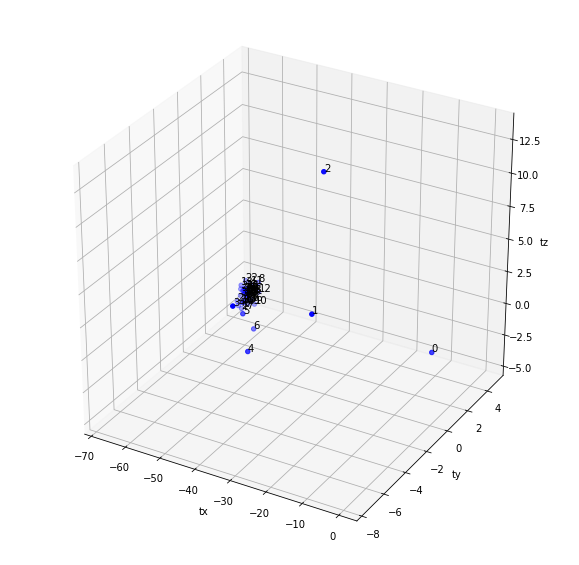

In [34]:
from mpl_toolkits.mplot3d import Axes3D

xyz_trajectory = np.array([t[[3,7,11]] for t in aligner.Ts])

fig = plt.figure(figsize=(10,10));
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_trajectory[::5,0], xyz_trajectory[::5,1], xyz_trajectory[::5,2], c='b', marker='o')
ax.set_xlabel('tx')
ax.set_ylabel('ty')
ax.set_zlabel('tz')
for i, (x,y,z) in enumerate(xyz_trajectory[::5]):
    ax.text(x,y,z,str(i))
plt.show()

In [34]:
# converged_scores = np.array([s[-1] for s in scores_all_trials])
# q3 = np.percentile(converged_scores, 55)
# q1 = np.percentile(converged_scores, 45)
# iqr = q3 - q1
# inlier_min = q1 - 1.5 * iqr
# inlier_max = q3 + 1.5 * iqr
# inliers = np.where((converged_scores > inlier_min) & (converged_scores < inlier_max))[0]
# print 'inliers', inliers

# plt.figure();
# for trial_idx, scores in enumerate(scores_all_trials):
#     plt.plot(scores, label='trial ' + str(trial_idx));
# plt.xlabel('Iteration');
# plt.ylabel('Score');
# plt.legend();
# plt.title('Score evolution for different optimization runs');

# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# T_all_trials = np.array(T_all_trials)
# t_std = np.std(pca.fit_transform(T_all_trials[inliers[:,None] ,[3,7,11]])[0])
# t_std_um = t_std * XY_PIXEL_DISTANCE_TB
# print 'Widest standard deviation of converged translation parameters for different trials: %.2f voxels, %.2f um' % (t_std, t_std_um)

In [31]:
# tx_std = np.std(T_all_trials[inliers, 3])
# ty_std = np.std(T_all_trials[inliers, 7])
# tz_std = np.std(T_all_trials[inliers, 11])
# tx_std_um = tx_std * XY_PIXEL_DISTANCE_TB
# ty_std_um = ty_std * XY_PIXEL_DISTANCE_TB
# tz_std_um = tz_std * XY_PIXEL_DISTANCE_TB
# print 'tx std:', tx_std, 'voxels', tx_std_um, 'um'
# print 'ty std:', ty_std, 'voxels', ty_std_um, 'um'
# print 'tz std:', tz_std, 'voxels', tz_std_um, 'um'

# print np.linalg.norm([tx_std_um, ty_std_um, tz_std_um]), 'um'

# plt.scatter(np.ones((5,)), np.array(T_all_trials)[:, 3], marker='+');
# plt.scatter(2*np.ones((5,)), np.array(T_all_trials)[:, 7], marker='+');
# plt.scatter(3*np.ones((5,)), np.array(T_all_trials)[:, 11], marker='+');

In [35]:
Ts = np.array(aligner.Ts)

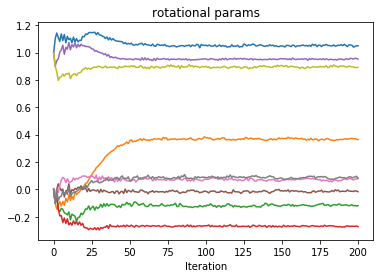

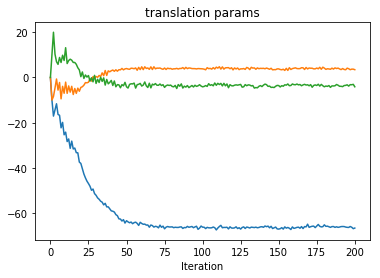

In [36]:
plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

In [119]:
# history_len = 20

# for i in [0,1,2,4,5,6,8,9,10]:
#     std_evolution = [np.std(Ts[t-history_len:t,i]) if t > history_len else np.nan for t in range(len(Ts))]
#     plt.plot(std_evolution);
#     plt.ylim([0, 0.02]);
#     plt.show();
    
# for i in [3,7,11]:
#     std_evolution = [np.std(Ts[t-history_len:t,i]) if t > history_len else np.nan for t in range(len(Ts))]
#     plt.plot(std_evolution);
#     plt.title('trans');
#     plt.ylim([0, 1]);
#     plt.show();

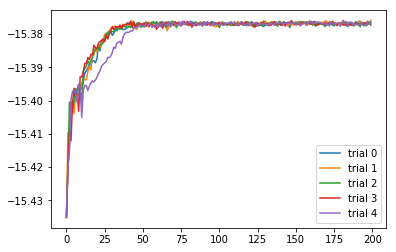

In [37]:
for trial_idx in range(5):
    try:
        scores = scores_all_trials[trial_idx]
        plt.plot(scores, label='trial '+ str(trial_idx));
    except Exception as e:
        sys.stderr.write('Scores for trial %d does not exist.\n' % (trial_idx))
        continue
plt.legend()
plt.show()

Best trial: 0
-15.3746951713 -15.3761448185
[[  9.16156517e-01   4.29397060e-01  -8.29759487e-02  -5.01460802e+01]
 [ -2.76807946e-01   9.79143824e-01   2.19254197e-01   9.55371292e-01]
 [  5.42928229e-03  -3.24786036e-01   8.75358873e-01   2.98745149e+01]]


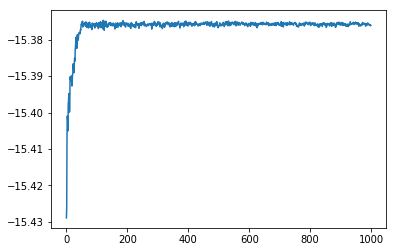

In [35]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [25]:
# print T.reshape((3,4))
# plt.plot(scores);
# print max(scores), scores[-1]

# Export parameters and score plots

In [239]:
from data_manager import *

In [240]:
for trial_idx in range(trial_num):
    
    T = T_all_trials[trial_idx]
    scores = scores_all_trials[trial_idx]
    traj = traj_all_trials[trial_idx]
    
    ##################################

    params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  detector_id_f=detector_id,
                                                  prep_id_f=2,
                                                  warp_setting=warp_setting,
                                                 trial_idx=trial_idx, what='parameters')
    DataManager.save_alignment_parameters(params_fp, T, 
                                          aligner.centroid_m, aligner.centroid_f,
                                          aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                          aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
    upload_to_s3(params_fp)

    ##################################
    
    history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  detector_id_f=detector_id,
                                                  prep_id_f=2,
                                                  warp_setting=warp_setting,
                                                 trial_idx=trial_idx, what='scoreHistory')
    bp.pack_ndarray_file(np.array(scores), history_fp)
    upload_to_s3(history_fp)

    ##################################
    
    score_plot_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  detector_id_f=detector_id,
                                                  prep_id_f=2,
                                                  warp_setting=warp_setting,
                                                 trial_idx=trial_idx, what='scoreEvolution')
    fig = plt.figure();
    plt.plot(scores);
    plt.savefig(score_plot_fp, bbox_inches='tight')
    plt.close(fig)

    upload_to_s3(score_plot_fp)
    
    ##################################
    
    trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  detector_id_f=detector_id,
                                                  prep_id_f=2,
                                                  warp_setting=warp_setting,
                                                 trial_idx=trial_idx, what='trajectory')
    bp.pack_ndarray_file(np.array(traj), trajectory_fp)
    upload_to_s3(trajectory_fp)

aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp20_MD602_prep2_detector15_down32_scoreVolume_trial_0/atlasV5_down32_scoreVolume_warp20_MD602_prep2_detector15_down32_scoreVolume_trial_0_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp20_MD602_prep2_detector15_down32_scoreVolume_trial_0/atlasV5_down32_scoreVolume_warp20_MD602_prep2_detector15_down32_scoreVolume_trial_0_parameters.txt"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp20_MD602_prep2_detector15_down32_scoreVolume_trial_0/atlasV5_down32_scoreVolume_warp20_MD602_prep2_detector15_down32_scoreVolume_trial_0_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp20_MD602_prep2_detector15_down32_scoreVolume_trial_0/atlasV5_down32_scoreVolume_warp20_MD602_prep2_detector15_down32_scoreVolume_trial_0_scoreHistory.bp"
aws s3 cp "/shared/CSH

# Draw Results

In [36]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (affine_components_to_vector(-9.77304587,  48.73149657,  -2.80149108,  -0.16628751), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,130,0,1,0,-70,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (grid_search_T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)


global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(aligner.Ts[-1], 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,0,0,1,0,0,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [37]:
print global_params.reshape((3,4))

[[  9.22900813e-01   4.26436289e-01  -7.62469665e-02  -5.01444940e+01]
 [ -2.82618059e-01   9.87182390e-01   2.31381400e-01   1.46525203e+00]
 [  8.28426693e-03  -3.38359456e-01   8.74602296e-01   2.98133979e+01]]


In [41]:
# Transform moving volume, sided, without surround

structure = 'Pn_L'

vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

volume_m_alignedTo_f = \
transform_volume(vol=vol_m, global_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f,
                  xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)

In [42]:
# Set colors for different contour level
levels = [0.1, 0.25, 0.5, 0.75, .99]
level_colors = {level: (int(level*255),0,0) for level in levels}

0 573 0 413 93 452
rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_prep2_down8_Pn_detector15_scoremapViz.jpg"
rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/

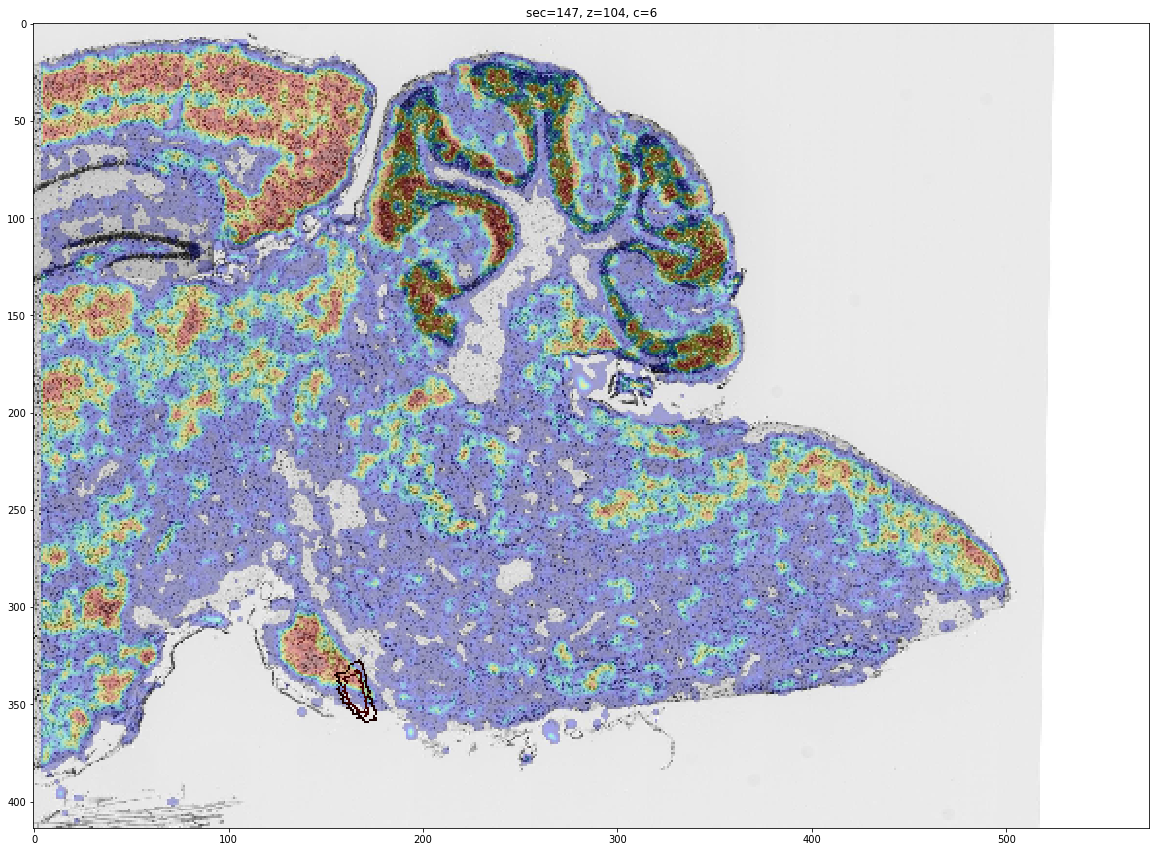

rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_prep2_down8_Pn_detector15_scoremapViz.jpg"


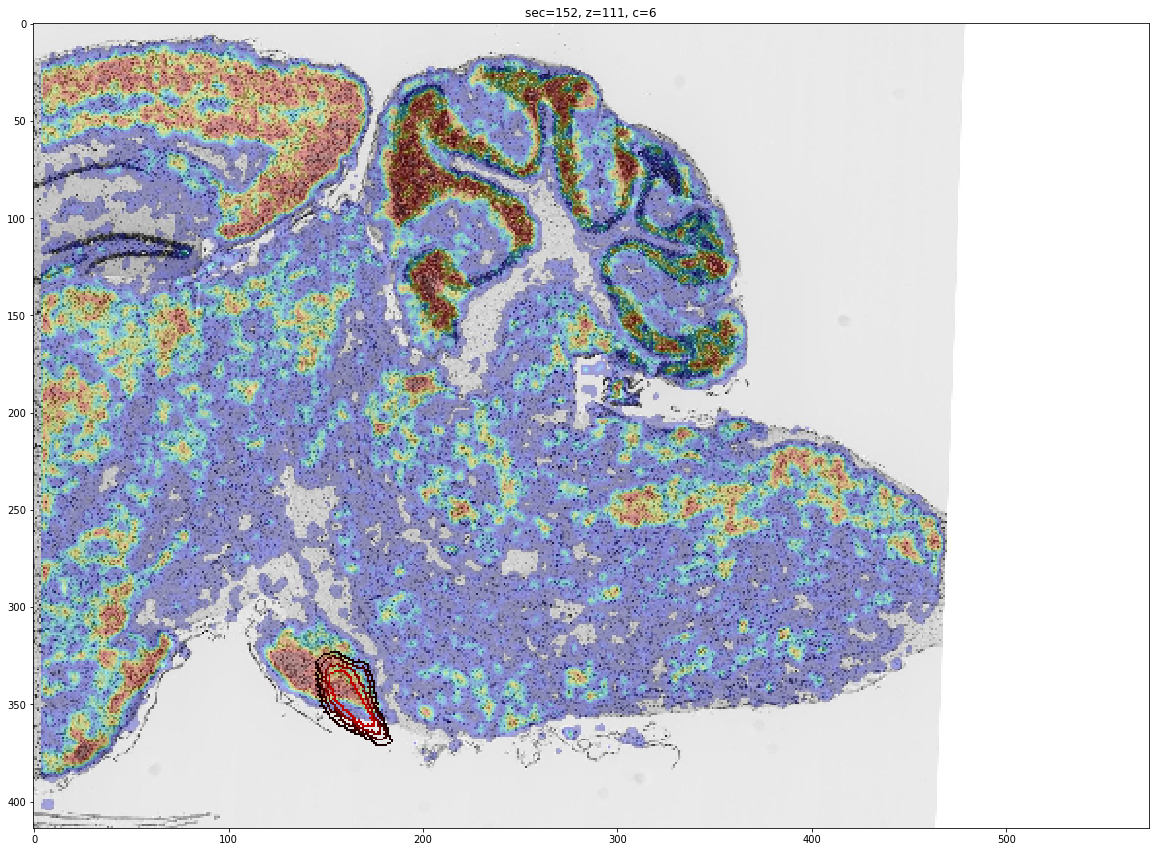

rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_prep2_down8_Pn_detector15_scoremapViz.jpg"


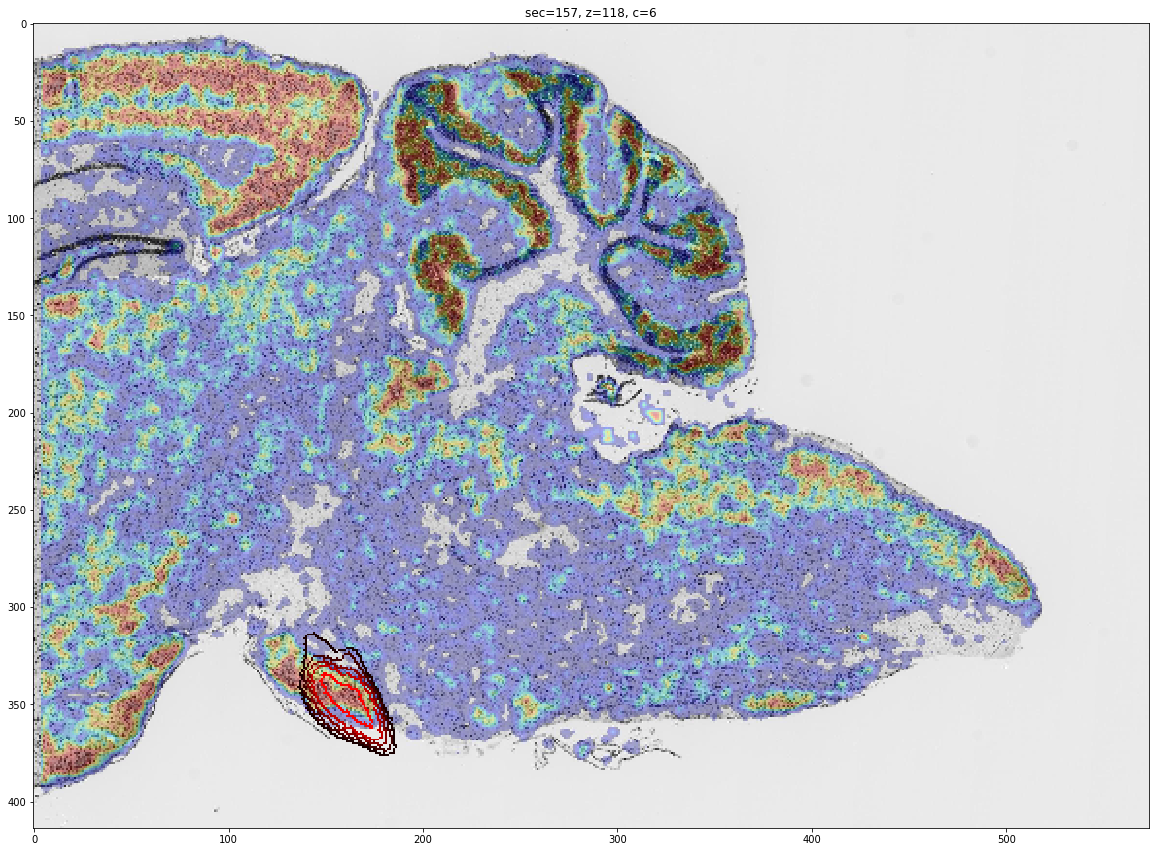

rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_prep2_down8_Pn_detector15_scoremapViz.jpg"


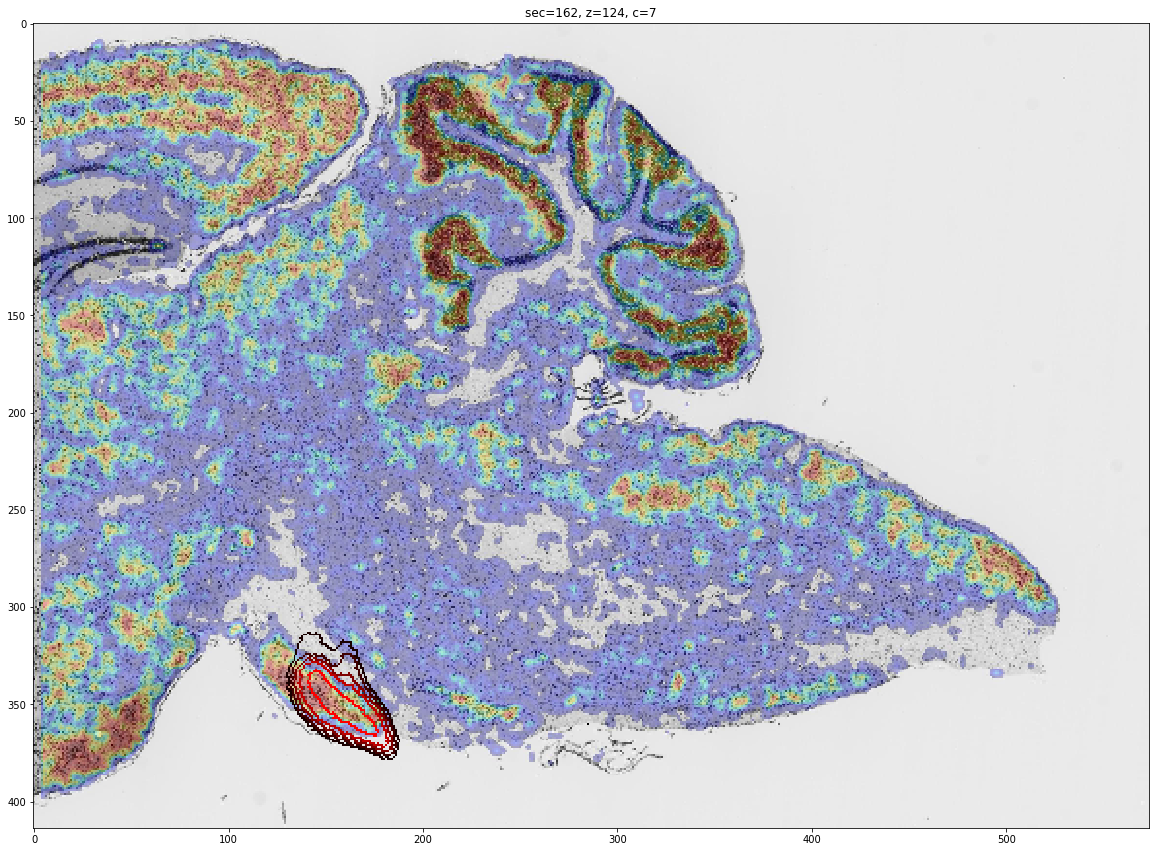

rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_prep2_down8_Pn_detector15_scoremapViz.jpg"


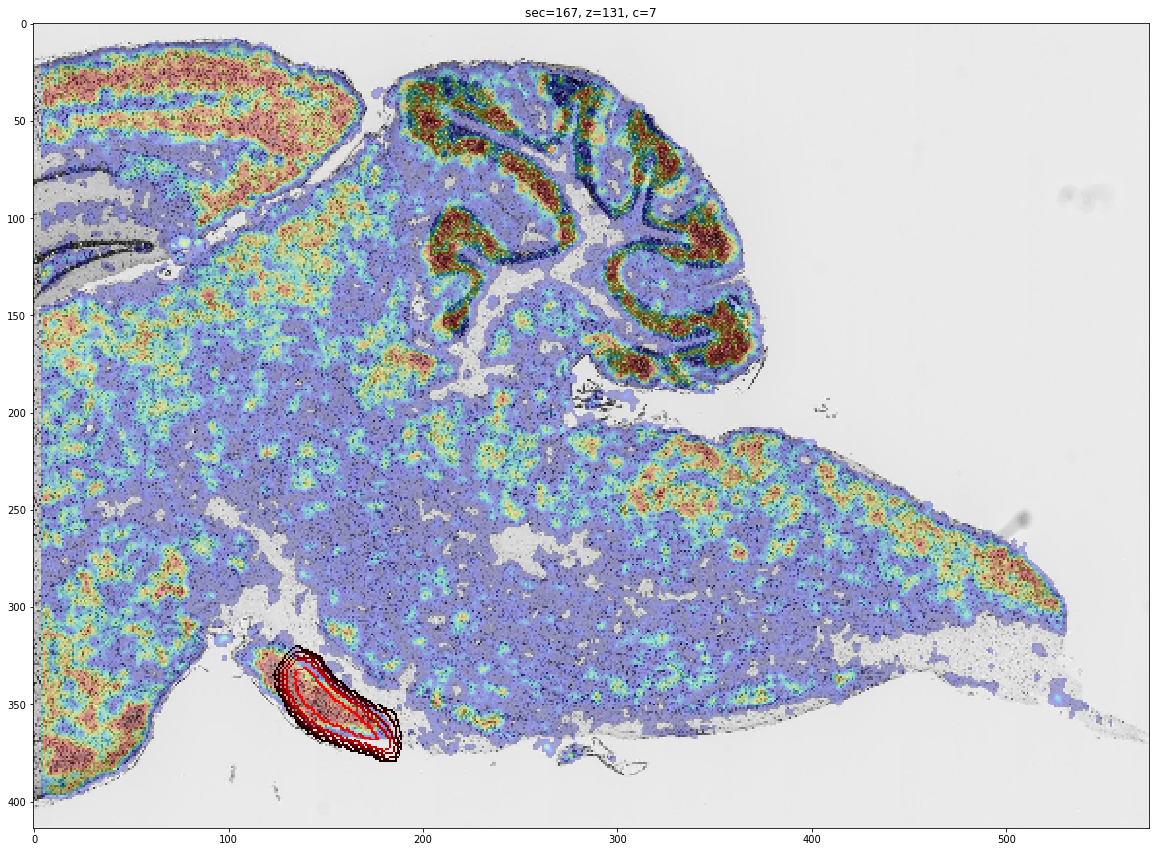

rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_prep2_down8_Pn_detector15_scoremapViz.jpg"


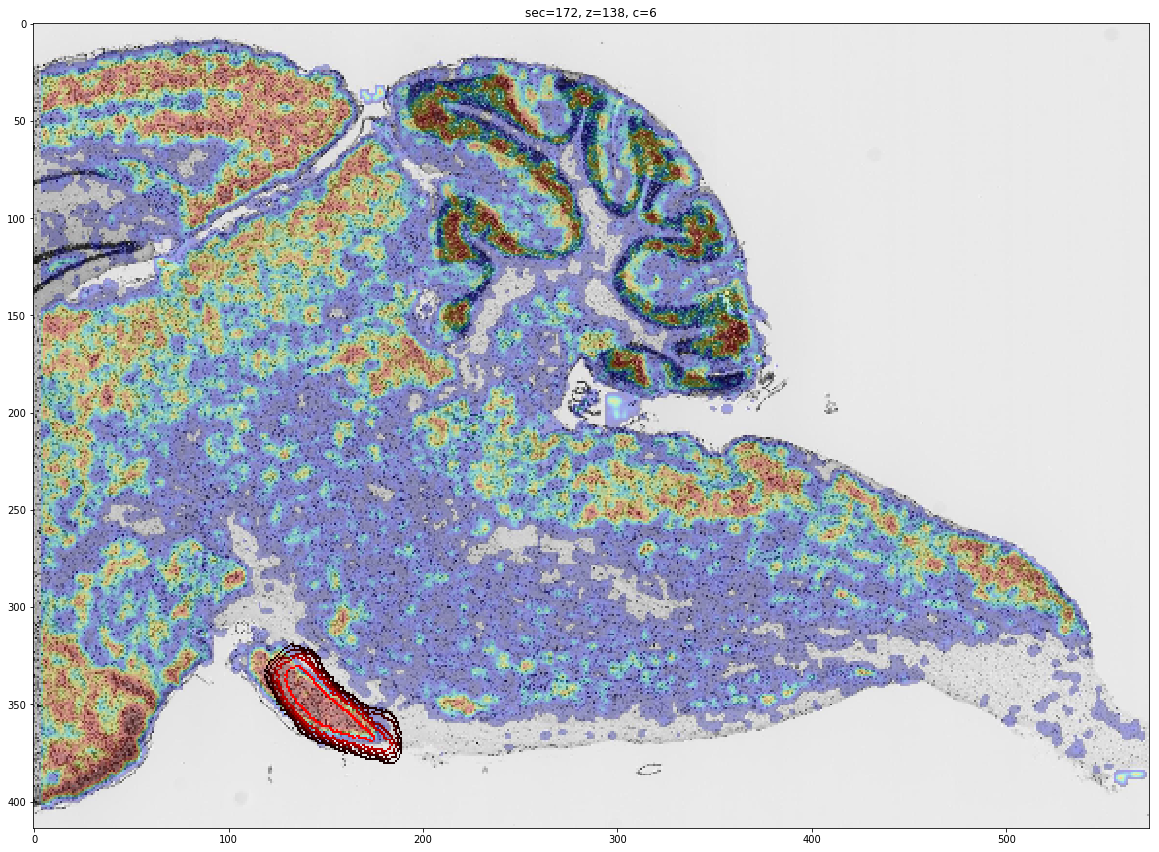

rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_prep2_down8_Pn_detector15_scoremapViz.jpg"


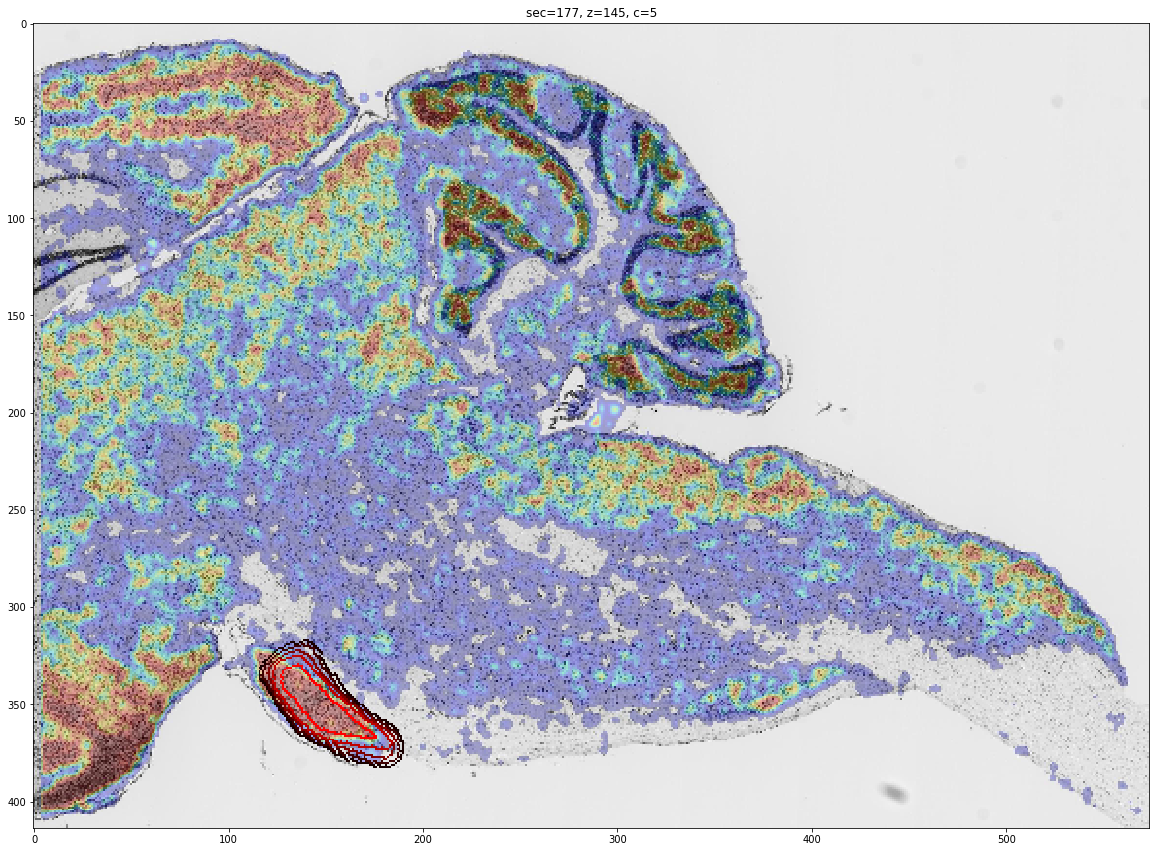

rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_prep2_down8_Pn_detector15_scoremapViz.jpg"


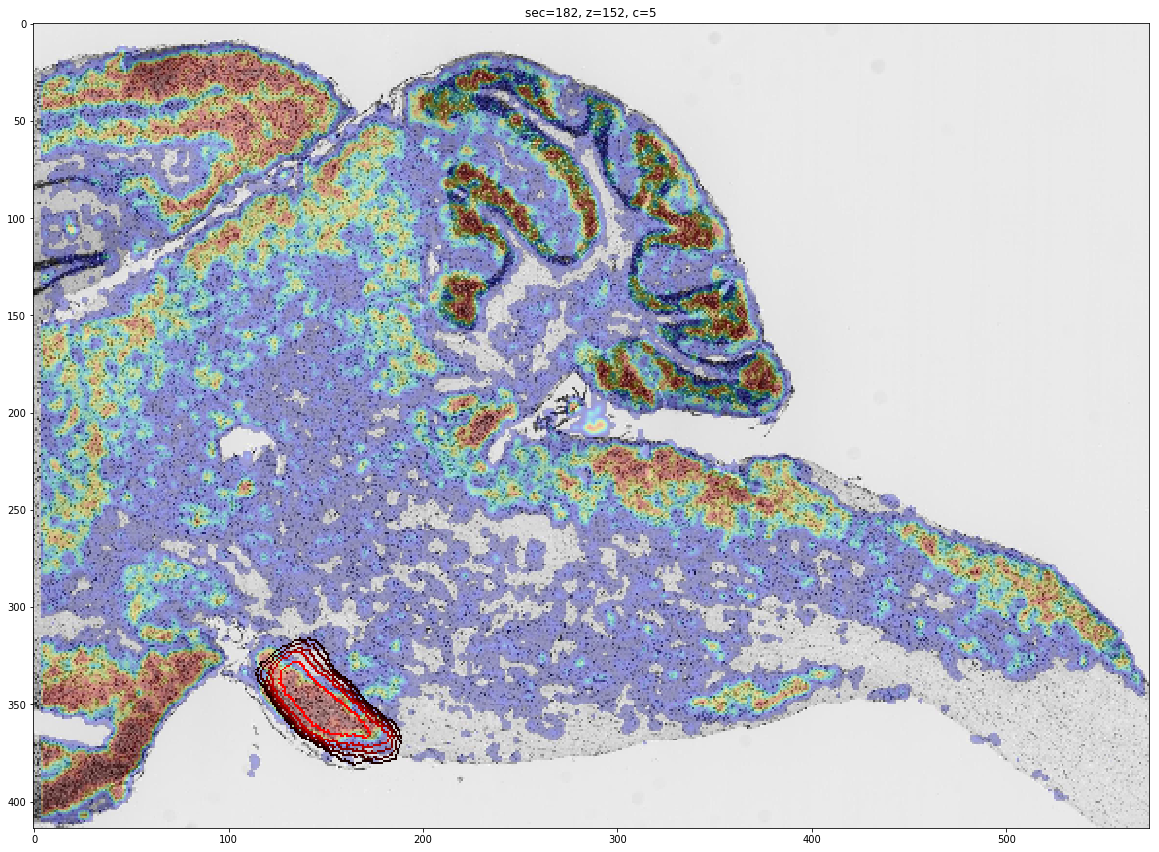

rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_prep2_down8_Pn_detector15_scoremapViz.jpg"


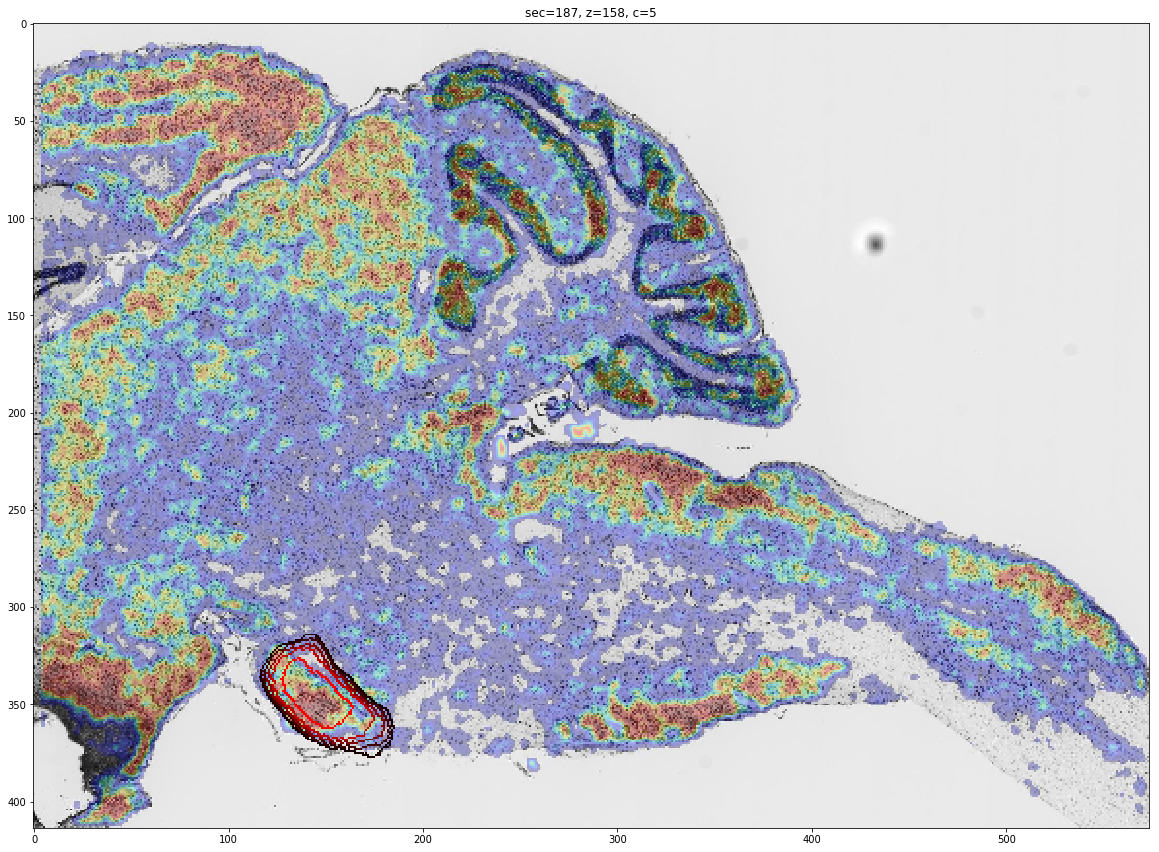

rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_prep2_down8_Pn_detector15_scoremapViz.jpg"


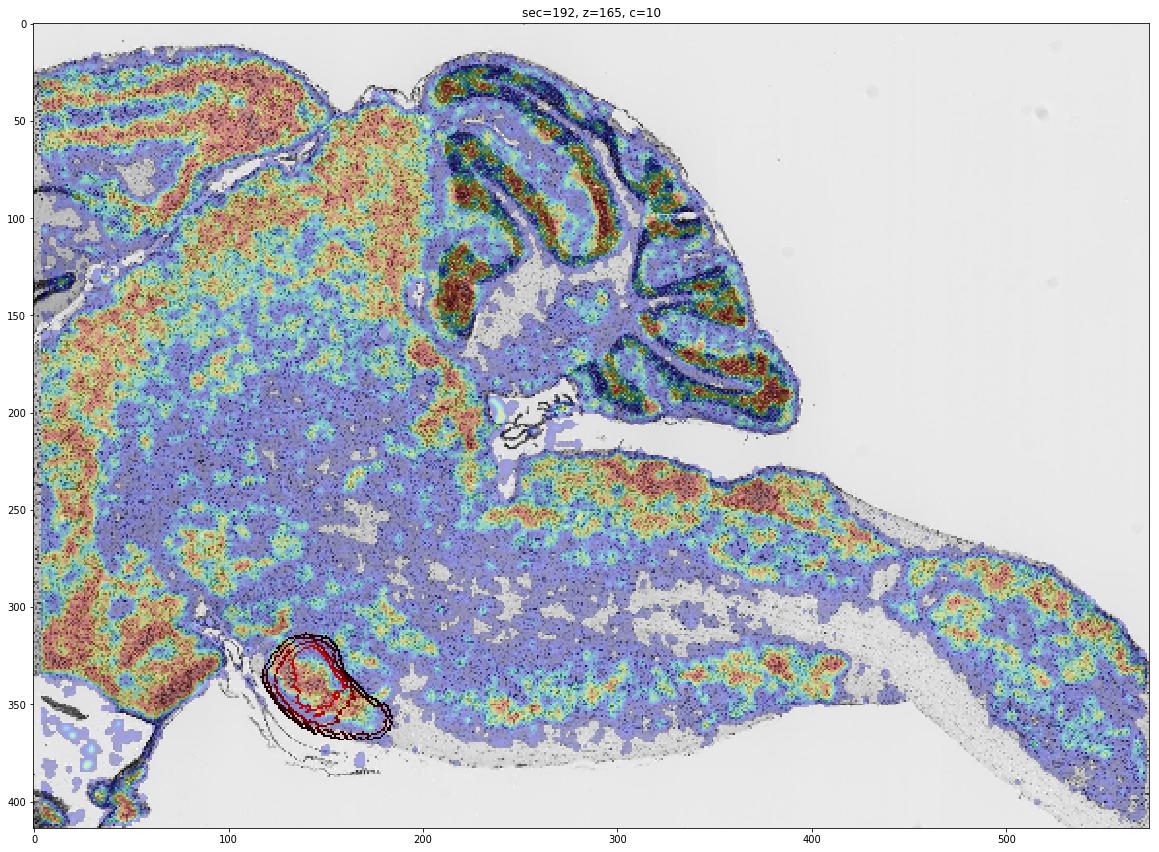

rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_prep2_down8_Pn_detector15_scoremapViz.jpg"


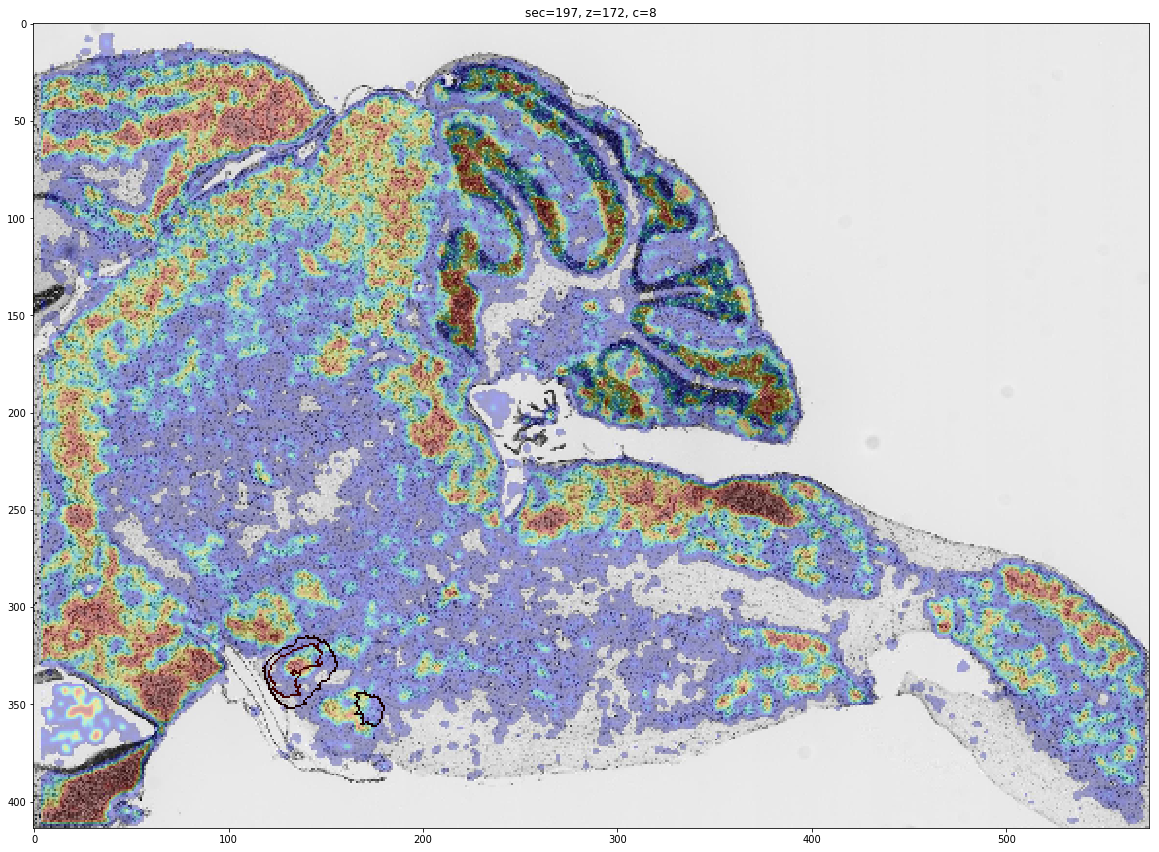

rm -rf "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_prep2_down8_Pn_detector15_scoremapViz.jpg" && mkdir -p "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2"
aws s3 cp "s3://mousebrainatlas-data/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_prep2_down8_Pn_detector15_scoremapViz.jpg" "/shared/CSHL_scoremap_viz/down8/Pn/MD595/detector15/prep2/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_prep2_down8_Pn_detector15_scoremapViz.jpg"


In [43]:
# Generate overlay visualization

# For getting correct contour location

xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = \
DataManager.load_original_volume_bbox(stack=stack_fixed, volume_type='score', structure='7N', 
                             downscale=32, detector_id=detector_id, prep_id=2)
print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

# Generate atlas overlay image for every section

zf, zl = bbox_3d(volume_m_alignedTo_f)[4:]
sec_first = DataManager.convert_z_to_section(stack=stack_fixed, z=zf, downsample=32)
sec_last = DataManager.convert_z_to_section(stack=stack_fixed, z=zl, downsample=32)

for sec in range(sec_first, sec_last+1, 5):
# for sec in [155]:
    
    if is_invalid(metadata_cache['sections_to_filenames'][stack_fixed][sec]):
        continue
    
    try:
#         img = DataManager.load_image(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
        sc_viz_fp = DataManager.get_scoremap_viz_filepath(stack=stack_fixed, section=sec, 
                                                           downscale=8,
                                                           structure=convert_to_original_name(structure), 
                                                           detector_id=detector_id, prep_id=2)
        download_from_s3(sc_viz_fp)
        img = imread(sc_viz_fp)[::4, ::4]
#         sc_viz_fp = DataManager.get_scoremap_viz_filepath(stack=stack_fixed, section=sec, 
#                                                            downscale=32,
#                                                            structure=convert_to_original_name(structure), 
#                                                            detector_id=detector_id, prep_id=2)
#         download_from_s3(sc_viz_fp)
#         img = imread(sc_viz_fp)
    except:
        sys.stderr.write('Error loading scoremap for section %d\n' % sec)
        continue
    
    viz = img.copy()
    
    z1, z2 = DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=32)
    z = int(z1)
    
    # Find moving volume annotation contours
    c = 0
    vol = volume_m_alignedTo_f
    for level in levels:
        cnts = find_contours(vol[..., z], level=level) # rows, cols
        c += len(cnts)
        for cnt in cnts:
            # r,c to x,y
            cnt_on_cropped = cnt[:, ::-1] + (xmin_vol_f, ymin_vol_f)
            cv2.polylines(viz, [cnt_on_cropped.astype(np.int)], True, level_colors[level], 1)
    
    if c > 0:    
        plt.figure(figsize=(20,20));
#         plt.figure();
        plt.title("sec=%d, z=%d, c=%d" % (sec, z, c));
        plt.imshow(viz);
        plt.show();
